# Introduction

In [1]:
#Reset kernel when start this notebook
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

spark = SparkSession.builder.master('local[*]').getOrCreate()

sc = spark.sparkContext

spark

In [10]:
#Let's calculate the difference of time between the pick-up and the drop-off
df["difference_datetime"] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

In [11]:
df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,difference_datetime
2786484,2,2017-01-10 14:48:29,2017-01-10 14:50:12,2,0.28,1,N,236,75,2,3.0,0.0,0.5,0.00,0.0,0.3,3.80,0 days 00:01:43
5185903,1,2017-01-18 05:38:29,2017-01-18 05:46:56,1,2.90,1,N,236,233,2,10.5,0.5,0.5,0.00,0.0,0.3,11.80,0 days 00:08:27
6364471,1,2017-01-21 16:21:26,2017-01-21 16:31:19,3,3.10,1,N,261,79,1,11.5,0.0,0.5,2.45,0.0,0.3,14.75,0 days 00:09:53
3234268,1,2017-01-11 22:15:59,2017-01-11 22:26:25,1,1.30,1,N,48,229,2,8.0,0.5,0.5,0.00,0.0,0.3,9.30,0 days 00:10:26
5381761,1,2017-01-18 18:22:03,2017-01-18 18:25:51,1,0.40,1,N,162,141,1,4.5,1.0,0.5,1.00,0.0,0.3,7.30,0 days 00:03:48
3941871,1,2017-01-14 00:27:22,2017-01-14 00:45:42,2,6.90,1,N,112,95,1,22.0,0.5,0.5,4.65,0.0,0.3,27.95,0 days 00:18:20
6566881,2,2017-01-22 05:35:51,2017-01-22 05:39:14,5,0.63,1,N,230,48,1,4.5,0.5,0.5,1.00,0.0,0.3,6.80,0 days 00:03:23
3575608,1,2017-01-12 23:57:46,2017-01-13 00:11:42,2,3.90,1,N,257,165,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30,0 days 00:13:56
5798972,2,2017-01-19 22:13:02,2017-01-19 22:19:54,5,1.51,1,N,239,237,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0 days 00:06:52
820659,1,2017-01-04 07:57:21,2017-01-04 07:59:37,3,0.30,1,N,41,41,1,3.5,0.0,0.5,0.00,0.0,0.3,4.30,0 days 00:02:16


In [13]:
df["difference_sec"] = df["difference_datetime"].dt.total_seconds()

In [14]:
#Calculate the velocity: milles per hour
df["velocity"] = df["trip_distance"] / ((df["difference_sec"]/60) /60)

In [15]:
#Check the hours of pickup and dropoff
df["pickup_hour"] = df["tpep_pickup_datetime"].apply(lambda x: x.hour)
df["dropoff_hour"] = df["tpep_dropoff_datetime"].apply(lambda x: x.hour)

In [16]:
#Calculate the velocity avg of each hour
hourly_average = df.groupby("pickup_hour")["velocity"].mean()
hourly_average

pickup_hour
0           NaN
1     15.393956
2     34.002701
3     17.134252
4     22.101497
5     22.004298
6     22.873893
7     12.541328
8     11.049625
9     10.633622
10    11.167654
11    11.088057
12    10.557581
13    12.984105
14    11.989086
15    10.875872
16    11.493656
17    11.721121
18    10.306464
19    11.173227
20    12.511947
21    13.425837
22    14.166815
23    22.862930
Name: velocity, dtype: float64

As we can see, there are NaN values present most of the values. So, let's find what's is causing this.

In [17]:
#Let's check for values lower or equal to zero
df[df["difference_sec"] < 0]["VendorID"].count()

0

4 rows have difference_sec value below zero. It may indicate we are doing the minus operation between dates wrong. So, let's see the rows

In [18]:
df[df["difference_sec"] < 0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,difference_datetime,difference_sec,velocity,pickup_hour,dropoff_hour


In [19]:
#Now, let's check the zero values because it can generate errors in the division between distance/time.
df[df["difference_sec"] == 0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,difference_datetime,difference_sec,velocity,pickup_hour,dropoff_hour
3926223,1,2017-01-13 23:45:03,2017-01-13 23:45:03,1,0.0,1,N,234,264,2,...,0.5,0.0,0.0,0.3,10.8,0 days,0.0,NaN,23,23
5235383,1,2017-01-18 09:26:58,2017-01-18 09:26:58,1,0.0,1,N,230,264,2,...,0.5,0.0,0.0,0.3,14.3,0 days,0.0,NaN,9,9
1515770,1,2017-01-06 12:58:23,2017-01-06 12:58:23,2,0.0,1,N,158,264,2,...,0.5,0.0,0.0,0.3,6.8,0 days,0.0,NaN,12,12
3225048,1,2017-01-11 21:56:12,2017-01-11 21:56:12,1,0.0,1,N,158,264,2,...,0.5,0.0,0.0,0.3,7.8,0 days,0.0,NaN,21,21
2956791,1,2017-01-11 03:02:01,2017-01-11 03:02:01,1,0.0,1,N,148,264,2,...,0.5,0.0,0.0,0.3,3.8,0 days,0.0,NaN,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164949,1,2017-01-01 13:21:26,2017-01-01 13:21:26,1,0.0,1,N,236,264,2,...,0.5,0.0,0.0,0.3,6.3,0 days,0.0,NaN,13,13
707601,1,2017-01-03 18:00:56,2017-01-03 18:00:56,1,0.0,1,Y,41,264,2,...,0.5,0.0,0.0,0.3,14.3,0 days,0.0,NaN,18,18
2649650,1,2017-01-10 03:33:48,2017-01-10 03:33:48,1,0.0,1,N,264,264,2,...,0.5,0.0,0.0,0.3,3.8,0 days,0.0,NaN,3,3
6953965,1,2017-01-23 16:55:27,2017-01-23 16:55:27,1,0.0,1,N,114,264,2,...,0.5,0.0,0.0,0.3,16.8,0 days,0.0,NaN,16,16


As we can see, there are 4 records which their dropoff datetimes are before the pickup datetime which is incorrect. Also, there are 9339 rows that have the value zero in the column "difference_sec". So, let's remove them

In [20]:
df_cleaned = df[df["difference_sec"] > 0]

In [21]:
df_cleaned.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,difference_datetime,difference_sec,velocity,pickup_hour,dropoff_hour
2786484,2,2017-01-10 14:48:29,2017-01-10 14:50:12,2,0.28,1,N,236,75,2,...,0.5,0.00,0.0,0.3,3.80,0 days 00:01:43,103.0,9.786408,14,14
5185903,1,2017-01-18 05:38:29,2017-01-18 05:46:56,1,2.90,1,N,236,233,2,...,0.5,0.00,0.0,0.3,11.80,0 days 00:08:27,507.0,20.591716,5,5
6364471,1,2017-01-21 16:21:26,2017-01-21 16:31:19,3,3.10,1,N,261,79,1,...,0.5,2.45,0.0,0.3,14.75,0 days 00:09:53,593.0,18.819562,16,16
3234268,1,2017-01-11 22:15:59,2017-01-11 22:26:25,1,1.30,1,N,48,229,2,...,0.5,0.00,0.0,0.3,9.30,0 days 00:10:26,626.0,7.476038,22,22
5381761,1,2017-01-18 18:22:03,2017-01-18 18:25:51,1,0.40,1,N,162,141,1,...,0.5,1.00,0.0,0.3,7.30,0 days 00:03:48,228.0,6.315789,18,18
3941871,1,2017-01-14 00:27:22,2017-01-14 00:45:42,2,6.90,1,N,112,95,1,...,0.5,4.65,0.0,0.3,27.95,0 days 00:18:20,1100.0,22.581818,0,0
6566881,2,2017-01-22 05:35:51,2017-01-22 05:39:14,5,0.63,1,N,230,48,1,...,0.5,1.00,0.0,0.3,6.80,0 days 00:03:23,203.0,11.172414,5,5
3575608,1,2017-01-12 23:57:46,2017-01-13 00:11:42,2,3.90,1,N,257,165,2,...,0.5,0.00,0.0,0.3,15.30,0 days 00:13:56,836.0,16.794258,23,0
5798972,2,2017-01-19 22:13:02,2017-01-19 22:19:54,5,1.51,1,N,239,237,1,...,0.5,1.76,0.0,0.3,10.56,0 days 00:06:52,412.0,13.194175,22,22
820659,1,2017-01-04 07:57:21,2017-01-04 07:59:37,3,0.30,1,N,41,41,1,...,0.5,0.00,0.0,0.3,4.30,0 days 00:02:16,136.0,7.941176,7,7


In [23]:
hourly_average = df_cleaned[["pickup_hour","velocity"]].groupby("pickup_hour")["velocity"].mean()
hourly_average

pickup_hour
0     15.016480
1     16.734651
2     17.813468
3     18.390434
4     18.301832
5     19.366486
6     16.498658
7     13.031049
8     10.677644
9     15.376289
10    10.788348
11    16.240133
12    11.153757
13    11.790319
14    10.883836
15    11.009431
16    10.709786
17    10.097071
18    10.480370
19    14.598672
20    13.323199
21    13.333277
22    16.484982
23    15.908279
Name: velocity, dtype: float64

In [22]:
temp = hourly_average.to_frame().reset_index()
temp

,pickup_hour,velocity
0,0,NaN
1,1,15.393956
2,2,34.002701
3,3,17.134252
4,4,22.101497
5,5,22.004298
6,6,22.873893
7,7,12.541328
8,8,11.049625
9,9,10.633622


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter

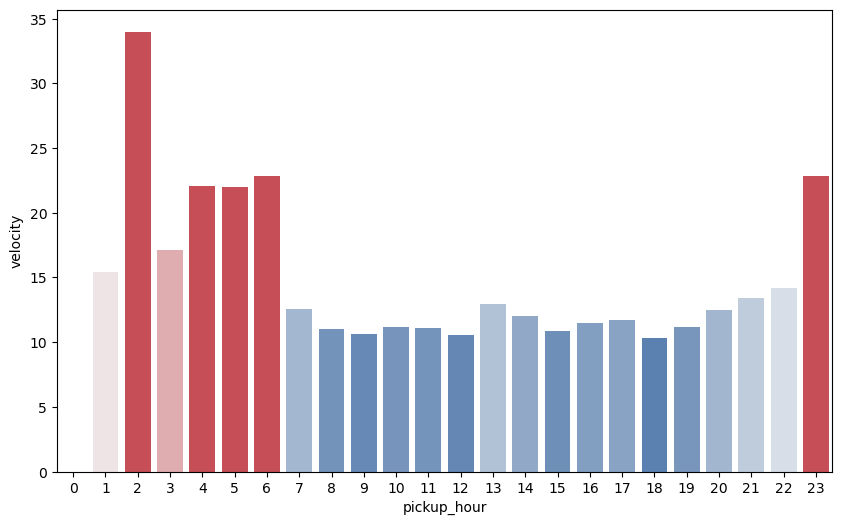

In [24]:
# You can adjust this value to control the center of the color transition
center_value = 10
intensity = (temp.velocity - center_value) / (center_value)

# Create a custom diverging color palette
custom_palette = sns.diverging_palette(250, 10, as_cmap=True)

plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=temp, x="pickup_hour", y="velocity", palette=custom_palette(intensity))

# Show the plot
plt.show()

As we can see, the plot shows the average velocity in each hour of the day. The higher velocities are present before and after midnight with a peak at 5am. It could be due to the low trafic and presence of pedestrians on the streets.

In [25]:
df_filtered = df_cleaned[["PULocationID","DOLocationID","trip_distance","tolls_amount","total_amount"]]
df_filtered.head(10)

,PULocationID,DOLocationID,trip_distance,tolls_amount,total_amount
2786484,236,75,0.28,0.0,3.80
5185903,236,233,2.90,0.0,11.80
6364471,261,79,3.10,0.0,14.75
3234268,48,229,1.30,0.0,9.30
5381761,162,141,0.40,0.0,7.30
3941871,112,95,6.90,0.0,27.95
6566881,230,48,0.63,0.0,6.80
3575608,257,165,3.90,0.0,15.30
5798972,239,237,1.51,0.0,10.56
820659,41,41,0.30,0.0,4.30


Before to continue, let's add the names of the zone for a better understanding

In [45]:
df_zones = pd.read_csv("dataset/taxi_zone_lookup.csv")
df_zones.head(5)

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [48]:
# Merge df_filtered with df_zones for pickup location names
merged_df = df_filtered.merge(df_zones, left_on='PULocationID', right_on='LocationID', how='left')

In [ ]:
# Rename the LocationID column to pickup_location_name
merged_df.rename(columns={'Borough': 'BoroughPickUp','ZonePickUp':}, inplace=True)

In [47]:
df_filtered["PUZone"] = df_zones[df_zones.LocationID == df_filtered.PULocationID]

ValueError: Can only compare identically-labeled Series objects

In [40]:
#Let's group the rows based on the origin and the destination of the trips
#Here, we can see the 10 of the most frequent routes 
df_filtered.groupby(["PULocationID","DOLocationID"])["total_amount"].count().sort_values(ascending=False).head(10)

PULocationID  DOLocationID
264           264             1433
237           236              606
236           236              530
              237              493
237           237              452
239           238              301
              142              294
142           239              265
79            79               252
237           162              250
Name: total_amount, dtype: int64

In [38]:
df_filtered.groupby(["PULocationID","DOLocationID"])["total_amount"].sum().sort_values(ascending=False).head(10)

PULocationID  DOLocationID
264           264             20756.51
132           230              5981.62
138           230              5490.18
237           236              5015.53
138           161              4678.01
              162              4563.90
236           237              4436.99
132           164              4110.13
              265              3873.99
230           138              3850.63
Name: total_amount, dtype: float64

# Data Analysis

* As Spark Dataframes operations are lazy, we need to use show() to trigger the computation and see the results

Data dictionary of this dataset can be found in the following link:
https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

In [76]:
sdf = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("dataset/yellow_tripdata_2017-01.parquet")

In [77]:
#Check the type of data of each column
sdf.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: integer (nullable = true)
 |-- airport_fee: integer (nullable = true)



In [78]:
#See the number of records
sdf.count()

9710820

9'710.820 - 4'856.845

## Null values

In [79]:
from pyspark.sql.functions import col, sum, when, expr

In [80]:
# Create a list of expressions that count null values for each column
null_counts = [sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in sdf.columns]

# Apply the expressions to the DataFrame and display the result
# The '*' is used to unpack the list and pass each expression as separete arg
# The agg funciton is to apply the expressions to the dataframe 'sdf'
sdf.agg(*null_counts).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|              0|            0|         0|                 0|           0|           0|           0|          0|    0|      0|         

In [81]:
#The 'congestion_surcharge' and 'airport_fee' columns are null, let's remove them
sdf = sdf.drop(*["congestion_surcharge","airport_fee"])

## Take a sample from the dataset
Select a set of records randomly to limit the size of the dataset, thus executing operations easier

In [82]:
sdf = sdf.sample(withReplacement=False, fraction=0.5, seed=15)
new_size = sdf.count()
print(f"Size of the sample '{new_size}'")

Size of the sameple '4856845'


# Estudio #4 - Taxi Velocity average in each hour

In [83]:
#Let's calculate the difference of time between the pick-up and the drop-off
sdf = sdf.withColumn("duration", col("tpep_dropoff_datetime")-col("tpep_pickup_datetime"))
sdf.select("duration").show()

+--------------------+
|            duration|
+--------------------+
|INTERVAL '0 00:05...|
|INTERVAL '0 00:04...|
|INTERVAL '0 00:04...|
|INTERVAL '0 00:04...|
|INTERVAL '0 00:10...|
|INTERVAL '0 00:52...|
|INTERVAL '0 00:22...|
|INTERVAL '0 00:18...|
|INTERVAL '0 00:09...|
|INTERVAL '0 00:14...|
|INTERVAL '0 00:13...|
|INTERVAL '0 00:11...|
|INTERVAL '0 00:09...|
|INTERVAL '0 00:17...|
|INTERVAL '0 00:43...|
|INTERVAL '0 00:28...|
|INTERVAL '0 00:04...|
|INTERVAL '0 00:10...|
|INTERVAL '0 00:15...|
|INTERVAL '0 00:13...|
+--------------------+
only showing top 20 rows



### Check duration of trips

In [135]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, StringType

#convert to seconds manually through User defined functions (UDF)
def interval_to_seconds(interval):
    total_seconds = interval.total_seconds()
    return int(total_seconds)

interval_to_seconds_udf = udf(interval_to_seconds, IntegerType())

In [85]:
# Use the UDF to extract seconds and store in a new column
sdf = sdf.withColumn("duration", interval_to_seconds_udf(col("duration")))

# Show the DataFrame with the extracted seconds
sdf.select("duration").show()

+--------+
|duration|
+--------+
|     343|
|     257|
|     283|
|     267|
|     635|
|    3147|
|    1328|
|    1100|
|     566|
|     858|
|     790|
|     695|
|     590|
|    1039|
|    2637|
|    1731|
|     293|
|     640|
|     924|
|     812|
+--------+
only showing top 20 rows



In [86]:
#Let's check for some anomalities in this column
sdf.filter(col("duration") < 0).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|duration|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
|       1| 2017-01-10 15:15:25|  2017-01-06 00:23:28|              1|          3.0|         1|                 N|         246|         239|           1|       13.0|  0.0|    0.5|      2.75|         0.0|                  0.3|       16.55| -399117|
+--------+--

In [87]:
sdf.filter(col("duration") == 0).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|duration|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
|       1| 2017-01-01 00:22:40|  2017-01-01 00:22:40|              1|          0.0|         1|                 N|         166|         264|           2|        5.0|  0.5|    0.5|       0.0|         0.0|                  0.3|         6.3|       0|
|       1| 2

All the above records shows that all the trips where finished at the same time when started.

Because of all these records, we proceed to remove them

In [88]:
sdf = sdf.filter(col("duration") > 0)
size_after_reduction = sdf.count()
print(f"Size of the sample '{size_after_reduction}'")

Size of the sample '4852149'


### Calculate Velocity of each trip

In [93]:
#As the duration column is in seconds, we have to divide the value between 3600 to the value in hour units.
sdf = sdf.withColumn("velocity",col("trip_distance")/(col("duration")/3600))
sdf.select("velocity").show()

+------------------+
|          velocity|
+------------------+
| 12.59475218658892|
|  9.80544747081712|
|10.176678445229681|
|14.831460674157304|
| 17.00787401574803|
|2.8598665395614873|
|  8.94578313253012|
| 6.218181818181818|
|3.1802120141342756|
|11.748251748251747|
| 8.658227848101266|
| 15.53956834532374|
| 6.711864406779662|
| 4.504331087584216|
| 3.372013651877133|
|  9.98266897746967|
|7.3720136518771335|
|            6.1875|
| 8.571428571428573|
|12.413793103448274|
+------------------+
only showing top 20 rows



*The units of these values are miles per hour

### Calculate avg per hour

In [94]:
from pyspark.sql.functions import hour

In [95]:
sdf = sdf.withColumn("hour_pickup", hour(col("tpep_pickup_datetime")))
sdf = sdf.withColumn("hour_dropoff", hour(col("tpep_dropoff_datetime")))
sdf.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+-----------+------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|duration|hour_pickup|hour_dropoff|          velocity|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+-----------+------------+------------------+
|       1| 2017-01-01 00:32:05|  2017-01-01 00:37:48|              1|          1.2|         1|                 N|         140| 

In [109]:
from pyspark.sql.functions import avg, max, min

In [99]:
result_df = sdf.groupBy("hour_pickup").agg(avg("velocity").alias("VelocityAvg")).orderBy("hour_pickup")

# Show the resulting DataFrame
result_df.show(24)

+-----------+------------------+
|hour_pickup|       VelocityAvg|
+-----------+------------------+
|          0|16.862296184551813|
|          1| 18.19212974346577|
|          2|17.607686833637203|
|          3| 18.64350165227927|
|          4| 20.86982963616253|
|          5|21.958015486494816|
|          6|17.945124479744575|
|          7| 13.95451747162792|
|          8| 11.74092416490247|
|          9|11.572896095635839|
|         10|12.052591991379755|
|         11|11.884868422854343|
|         12|11.781274686000831|
|         13|12.315182896055392|
|         14|12.184282020047453|
|         15| 11.45243996831902|
|         16|12.571602132692957|
|         17|11.845838274602547|
|         18|11.423740234720924|
|         19|12.816193454629271|
+-----------+------------------+
only showing top 20 rows



### Visualize results

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter

In [110]:
max = result_df.agg(max("VelocityAvg")).collect()[0][0]
min = result_df.agg(min("VelocityAvg")).collect()[0][0]

In [129]:
center_value = (max/min)/2

In [141]:
# Define a custom color mapping based on numeric values
def custom_color_palette(x):
    if x <= center_value:
        return "lightblue"  # Light blue for values less than 50
    else:
        return "lightred"  # Light green for values between 50 and 100

custom_color_palette_udf = udf(custom_color_palette, StringType())

result_df = result_df.withColumn("Color", custom_color_palette_udf(col("VelocityAvg")))

In [142]:
plt.figure(figsize=(10, 6))
result_df_p = result_df.toPandas()
barplot = sns.barplot(data=result_df_p, x="hour_pickup", y="VelocityAvg", palette=result_df_p["Color"])
plt.xlabel("Hour")
plt.ylabel("Average velocity")

# Show the plot
plt.show()

ValueError: Could not generate a palette for <map object at 0x7ff8bb479d50>

<Figure size 1000x600 with 0 Axes>